<a href="https://colab.research.google.com/github/dh610/ai-intensive2/blob/main/lab11/RLHF-trl-small.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/ai-intensive2
!git pull
%cd lab11

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/ai-intensive2
Already up to date.
/content/drive/MyDrive/ai-intensive2/lab11


In [5]:
!pip install -q transformers datasets trl peft

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModelForCausalLM
from trl import AutoModelForCausalLMWithValueHead
from peft import LoraConfig
import numpy as np
from pprint import pprint
from transformers.utils import logging

logging.set_verbosity_error()
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [7]:
reward_model_id = "OpenAssistant/reward-model-deberta-v3-large-v2"

rm_tokenizer = AutoTokenizer.from_pretrained(reward_model_id)
rm_model = AutoModelForSequenceClassification.from_pretrained(reward_model_id).eval().to(device)

if "cuda" in device:
  rm_model.half()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/455 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.66M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/993 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

In [8]:
@torch.no_grad()
def get_scores(prompts, answers, print_input=False):
  inputs = rm_tokenizer(prompts, answers,
                        truncation=True,
                        padding=True,
                        max_length=512,
                        return_tensors="pt").to(device)

  if print_input:
    print(rm_tokenizer.batch_decode(inputs["input_ids"], skip_special_tokens=False))
  scores = rm_model(**inputs).logits.squeeze(1)
  return scores

print(
    get_scores(
      ["I just came out of from jail, any suggestion of my future?"],
      ["It's great to hear that you have been released from jail."],
      True
    )
)
print(
    get_scores(
      ["I just came out of from jail, any suggestion of my future?"],
      ["Go back to jail you scum"],
      True
    )
)

["[CLS] I just came out of from jail, any suggestion of my future?[SEP] It's great to hear that you have been released from jail.[SEP]"]
tensor([-2.5898], device='cuda:0', dtype=torch.float16)
['[CLS] I just came out of from jail, any suggestion of my future?[SEP] Go back to jail you scum[SEP]']
tensor([-4.1523], device='cuda:0', dtype=torch.float16)


In [9]:
model_id = "vicgalle/gpt2-alpaca-gpt4"


query_tokenizer = AutoTokenizer.from_pretrained(model_id)
query_tokenizer.padding_side = "left"
query_tokenizer.truncation_side = "left"
if query_tokenizer.pad_token_id is None:
  query_tokenizer.pad_token_id = query_tokenizer.eos_token_id

response_tokenizer = AutoTokenizer.from_pretrained(model_id)
response_tokenizer.padding_side = "right"
response_tokenizer.truncation_side = "right"
if response_tokenizer.pad_token_id is None:
  response_tokenizer.pad_token_id = response_tokenizer.eos_token_id


tokenizer_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/80.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/230 [00:00<?, ?B/s]

In [10]:
def load_models():
  global active_model
  lora_config = LoraConfig(
      r=16,
      lora_alpha=32,
      lora_dropout=0.05,
      bias="none",
      task_type="CAUSAL_LM",
  )

  active_model = AutoModelForCausalLMWithValueHead.from_pretrained(
      model_id,
      peft_config=lora_config,
  ).eval().to(device)

load_models()

config.json:   0%|          | 0.00/908 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/510M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1150: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/510M [00:00<?, ?B/s]

In [11]:
# input_text = """Human: Give three tips for a good meal.

# Assistant: 1. Choose a healthy alternative to traditional fast food. This can include eating a nutritious breakfast, a healthy snack, and a healthy snack option.
# 2. Avoid excessive salt and sugar. Avoid any processed foods, such as processed eggs and sugary drinks.
# 3. Try a variety of healthy snacks. Try soft drinks, fruit juices, and other sugary foods.
# """
input_text = """Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Give three tips for a good meal.

### Response:
1. Choose a healthy alternative to traditional fast food. This can include eating a nutritious breakfast, a healthy snack, and a healthy snack option.
2. Avoid excessive salt and sugar. Avoid any processed foods, such as processed eggs and sugary drinks.
3. Try a variety of healthy snacks. Try soft drinks, fruit juices, and other sugary foods.
"""
with torch.no_grad():
  inputs = query_tokenizer(input_text, return_tensors="pt").to(device)
  logits, _, values = outputs = active_model(**inputs)
  print(logits.shape)
  print(values, values.shape)

torch.Size([1, 107, 50260])
tensor([[-0.0542,  3.7483,  2.6254,  2.8065,  2.9605,  3.4438,  3.5818,  3.5303,
          2.8936,  3.2310,  3.7718,  3.5725,  4.1216,  3.6745,  3.4137,  3.1978,
          2.9826,  3.0754, -0.5858,  4.3537,  3.8187,  5.0676,  3.8584,  2.7696,
          1.8833,  2.2848,  2.3037,  3.1186,  4.3937,  0.3596,  4.3656,  4.1338,
          2.7685,  1.9797,  2.4860,  3.0429,  3.3826,  2.8340,  2.8720,  3.1503,
          2.8295,  1.7064,  2.6617,  4.0624,  2.0908,  2.2525,  2.0654,  2.0210,
          3.3081,  2.6861,  2.7214,  3.1265,  3.1088,  3.3345,  2.7006,  2.3682,
          2.8975,  2.7273,  2.5610,  2.4427,  3.0471,  3.1970,  2.0588,  2.0526,
          2.2473,  3.5777,  2.6706,  3.4182,  1.2590,  2.2546,  2.3911,  2.6337,
          3.3242,  2.2671,  4.0542,  2.4546,  2.4506,  4.0766,  1.9381,  1.5996,
          2.4270,  3.5858,  2.2211,  5.1401,  4.4710,  1.8471,  2.3445,  1.9247,
          4.1956,  2.4805,  2.8689,  3.0573,  1.1610,  1.7570,  2.0062,  3.0880,


In [12]:

# 길이가 N인 배열을 batch_size 단위로 쪼개주는 함수
def batchify(items, batch_size):
  i = 0

  while i < len(items):
    yield items[i : i + batch_size]
    i += batch_size

  if i < len(items):
    yield items[i : ]

PROMPT_FORMAT = """Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
{prompt}

### Response:
"""

@torch.no_grad()
def rejection_sample(model, queries, minibatch_size, k=4, prompt_max_length=128, response_max_length=128, verbose=False):
  final_queries = []
  final_outputs = []
  final_scores = []

  for batch_prompt in batchify(queries, minibatch_size):
    batch_queries = [PROMPT_FORMAT.format(prompt=p) for p in batch_prompt]
    batch_query_inputs = query_tokenizer(batch_queries, padding=True, truncation=True, max_length=prompt_max_length, return_tensors="pt").to(device)

    bs = len(batch_queries)
    best_outputs = [""] * bs
    best_scores = [-float('Inf')] * bs


    # 프롬프트마다 K개의 답변 생성
    for _ in range(k):
      output_tokens = model.generate(**batch_query_inputs, do_sample=True, max_new_tokens=response_max_length, early_stopping=True)
      output_tokens = output_tokens[:, batch_query_inputs["input_ids"].shape[1]:]
      outputs = response_tokenizer.batch_decode(output_tokens, skip_special_tokens=True)
      outputs = [x.split("\n\n", 1)[0] for x in outputs]

      scores = get_scores(batch_queries, outputs).tolist()

      # 그 중에서 가장 score가 높은 값 가져오기
      for i, score in enumerate(scores):
        if best_scores[i] < score:
          best_outputs[i] = outputs[i]
          best_scores[i] = score

    final_queries.extend(batch_queries)
    final_outputs.extend(best_outputs)
    final_scores.extend(best_scores)

  if verbose:
    for query, response, score in zip(final_queries, final_outputs, final_scores):
      print(query, response, "\n", score)

  return final_queries, final_outputs, torch.tensor(final_scores, dtype=torch.float32, device=device)

queries, responses, scores = rejection_sample(
    active_model,
    [
        "I just came out of from jail, any suggestion of my future?",
        "What are the three primary colors?",
        "Describe the structure of an atom.",
    ],
    4,
    k=4,
    verbose=True
)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:638: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
I just came out of from jail, any suggestion of my future?

### Response:
 Yes! One possible future that I could create is going on a book tour and traveling the world. In that way, I could take the reader on a trip or travel through different cultures, exploring new countries, cultures and people, as well as meeting new people like myself. From there, I could use my knowledge of various languages to travel and discover new cultures, experiences, and experiences. It would be an exciting and rewarding journey, where I have the opportunity to share and learn more about different cultures and regions. 
 -3.005859375
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What are the three primary colors?

### Response:
 Three primary colors are blue, yellow, and orange. 
 3.001953125
Below is an ins

In [13]:
from datasets import load_dataset

prompt_dataset = load_dataset("HuggingFaceH4/helpful-instructions", split="train")
prompt_dataset[0]

README.md:   0%|          | 0.00/2.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/20.8M [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/12.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/147706 [00:00<?, ? examples/s]

{'instruction': 'Hi, I want to learn to play horseshoes. Can you teach me?',
 'demonstration': 'I can, but maybe I should begin by telling you that a typical game consists of 2 players and 6 or 8 horseshoes.',
 'meta': {'source': 'helpful-anthropic-raw'}}

# PPO

In [ ]:
from trl import PPOConfig, PPOTrainer

config = PPOConfig(
    learning_rate=1.41e-5,
    batch_size=4,
)

ppo_trainer = PPOTrainer(
    model=active_model,
    config=config,
    tokenizer=response_tokenizer
)

In [ ]:
from tqdm.auto import tqdm
from pprint import pprint

total_epochs = 1

histories = []

for epoch in range(total_epochs):
  for i in tqdm(range(0, len(prompt_dataset), config.batch_size)):
    queries = prompt_dataset[i : i + config.batch_size]["instruction"]

    # Rejection Sampling
    formatted_queries, responses, scores = rejection_sample(active_model, queries, config.mini_batch_size, k=2,
                                                            response_max_length=64)
    mean_scores = scores.mean()

    batch = dict(
      queries=queries,
      responses=responses
    )

    # tensor to list[tensor]
    query_tensors = [query_tokenizer(x, truncation=True, padding=True, max_length=128, return_tensors="pt")["input_ids"][0].to(device) for x in formatted_queries]
    response_tensors = [response_tokenizer(x, truncation=True, padding=True, max_length=128, return_tensors="pt")["input_ids"][0].to(device) for x in responses]
    scores = [score for score in scores]

    stats = ppo_trainer.step(query_tensors, response_tensors, scores)
    histories.append(stats)
    print({
      "kl": stats['objective/kl'],
      "scores": mean_scores
    })
    ppo_trainer.log_stats(stats, batch, scores)

  0%|          | 0/36927 [00:00<?, ?it/s]

{'kl': 0.03580187261104584, 'scores': tensor(-1.1687, device='cuda:0')}
{'kl': 0.060813602060079575, 'scores': tensor(-1.5161, device='cuda:0')}
{'kl': 0.22802217304706573, 'scores': tensor(-2.3132, device='cuda:0')}
{'kl': -0.04842400178313255, 'scores': tensor(-1.8421, device='cuda:0')}
{'kl': 0.3804830312728882, 'scores': tensor(-1.7361, device='cuda:0')}
{'kl': -0.14457851648330688, 'scores': tensor(-2.5063, device='cuda:0')}
{'kl': 0.6392930150032043, 'scores': tensor(-2.5116, device='cuda:0')}
{'kl': 0.20320120453834534, 'scores': tensor(-2.5283, device='cuda:0')}
{'kl': 0.8684059381484985, 'scores': tensor(-2.7495, device='cuda:0')}
{'kl': 1.1469488143920898, 'scores': tensor(-1.9622, device='cuda:0')}
{'kl': -0.10324744880199432, 'scores': tensor(-1.7907, device='cuda:0')}
{'kl': 0.8486300706863403, 'scores': tensor(-3.1221, device='cuda:0')}
{'kl': 1.0509779453277588, 'scores': tensor(-2.2168, device='cuda:0')}
{'kl': -0.9176238179206848, 'scores': tensor(-3.2158, device='cuda

/usr/local/lib/python3.10/dist-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -1.25 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


{'kl': -1.2461844682693481, 'scores': tensor(-2.3090, device='cuda:0')}
{'kl': 3.2979235649108887, 'scores': tensor(-1.5320, device='cuda:0')}
{'kl': 0.4497526288032532, 'scores': tensor(-2.5271, device='cuda:0')}
{'kl': 2.151308059692383, 'scores': tensor(-1.4517, device='cuda:0')}


/usr/local/lib/python3.10/dist-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -7.26 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


{'kl': -7.260945796966553, 'scores': tensor(-2.7515, device='cuda:0')}
{'kl': 3.250934600830078, 'scores': tensor(-2.9136, device='cuda:0')}
{'kl': 1.6790635585784912, 'scores': tensor(-2.8569, device='cuda:0')}
{'kl': 2.488314390182495, 'scores': tensor(-2.7764, device='cuda:0')}
{'kl': 1.3775005340576172, 'scores': tensor(-1.6792, device='cuda:0')}
{'kl': -0.027967453002929688, 'scores': tensor(-1.7340, device='cuda:0')}
{'kl': 1.4606363773345947, 'scores': tensor(-2.7002, device='cuda:0')}


/usr/local/lib/python3.10/dist-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -3.04 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


{'kl': -3.0383520126342773, 'scores': tensor(-2.2202, device='cuda:0')}
{'kl': 1.3043420314788818, 'scores': tensor(-1.6799, device='cuda:0')}
{'kl': 2.5159854888916016, 'scores': tensor(-2.1235, device='cuda:0')}
{'kl': 2.0150532722473145, 'scores': tensor(-2.6470, device='cuda:0')}
{'kl': 1.8182028532028198, 'scores': tensor(-1.8521, device='cuda:0')}


/usr/local/lib/python3.10/dist-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -2.20 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


{'kl': -2.1989855766296387, 'scores': tensor(-3.1382, device='cuda:0')}


/usr/local/lib/python3.10/dist-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -1.54 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


{'kl': -1.5423089265823364, 'scores': tensor(-2.3024, device='cuda:0')}
{'kl': 0.8163368701934814, 'scores': tensor(-2.5747, device='cuda:0')}
{'kl': 4.304385662078857, 'scores': tensor(-3.2263, device='cuda:0')}


/usr/local/lib/python3.10/dist-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -2.14 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


{'kl': -2.144503116607666, 'scores': tensor(-1.6169, device='cuda:0')}
{'kl': 2.881044864654541, 'scores': tensor(-2.4792, device='cuda:0')}
{'kl': 3.214892864227295, 'scores': tensor(-1.6321, device='cuda:0')}
{'kl': 1.1951920986175537, 'scores': tensor(-0.8999, device='cuda:0')}
{'kl': 1.59375, 'scores': tensor(-3.0566, device='cuda:0')}
{'kl': 2.5016355514526367, 'scores': tensor(-2.4534, device='cuda:0')}
{'kl': 0.036704301834106445, 'scores': tensor(-1.9138, device='cuda:0')}
{'kl': 2.7314422130584717, 'scores': tensor(-1.2058, device='cuda:0')}
{'kl': 6.212349891662598, 'scores': tensor(-2.7625, device='cuda:0')}
{'kl': 3.097752809524536, 'scores': tensor(-2.1775, device='cuda:0')}
{'kl': -0.6693531274795532, 'scores': tensor(-1.3121, device='cuda:0')}
{'kl': 3.644258499145508, 'scores': tensor(-2.6914, device='cuda:0')}
{'kl': 4.456670761108398, 'scores': tensor(-1.7236, device='cuda:0')}
{'kl': -0.2328220158815384, 'scores': tensor(-1.4316, device='cuda:0')}
{'kl': 3.0452873706

/usr/local/lib/python3.10/dist-packages/trl/trainer/ppo_trainer.py:1200: UserWarning: The average ratio of batch (17.92) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/ppo_trainer.py:1200: UserWarning: The average ratio of batch (169.81) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -1.13 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


{'kl': -1.1265497207641602, 'scores': tensor(-1.7808, device='cuda:0')}
{'kl': 2.9397175312042236, 'scores': tensor(-1.9392, device='cuda:0')}
{'kl': 0.9776164889335632, 'scores': tensor(-1.1018, device='cuda:0')}
{'kl': 2.284064531326294, 'scores': tensor(-2.4844, device='cuda:0')}
{'kl': 3.285173177719116, 'scores': tensor(-1.2047, device='cuda:0')}
{'kl': 4.0007758140563965, 'scores': tensor(-2.2166, device='cuda:0')}
{'kl': 1.6843491792678833, 'scores': tensor(-2.5522, device='cuda:0')}
{'kl': 0.8028077483177185, 'scores': tensor(-1.4395, device='cuda:0')}
{'kl': 2.421766996383667, 'scores': tensor(-2.2056, device='cuda:0')}
{'kl': 4.000665664672852, 'scores': tensor(-1.6772, device='cuda:0')}
{'kl': 1.19801926612854, 'scores': tensor(-1.8591, device='cuda:0')}
{'kl': 0.9175151586532593, 'scores': tensor(-2.0039, device='cuda:0')}
{'kl': 1.3444063663482666, 'scores': tensor(-0.8741, device='cuda:0')}
{'kl': 1.5529754161834717, 'scores': tensor(-1.3072, device='cuda:0')}
{'kl': 1.47

KeyboardInterrupt: ignored

<Axes: >

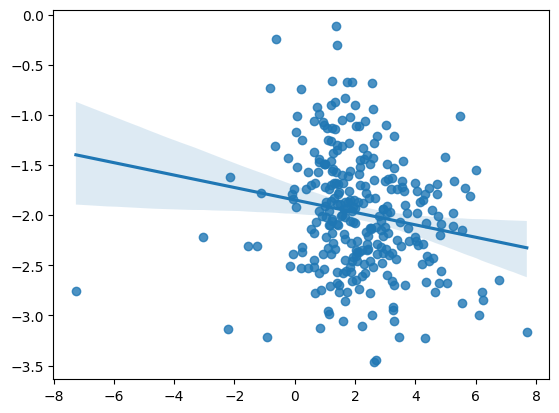

In [ ]:
import seaborn as sns

X = [x["objective/kl"] for x in histories]
Y = [x["ppo/mean_scores"] for x in histories]
sns.regplot(x=X, y=Y)

In [ ]:

queries, responses, scores = rejection_sample(
    active_model,
    [
        "I just came out of from jail, any suggestion of my future?",
        "What are the three primary colors?",
        "Describe the structure of an atom.",
    ],
    4,
    k=4,
    verbose=True
)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:418: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction: 
I just came out of from jail, any suggestion of my future?

### Response:
 Yes, I can see that there would be a great many more stories coming next. In the meantime, I hope to get your attention soon! 
 -3.87109375
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction: 
What are the three primary colors?

### Response:
 The three primary colors are blue, gray, and red.  
 1.4033203125
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction: 
Describe the structure of an atom.

### Response:
 An atom is a small nucleus where electrons move along the nuclear chain in a circular motion. Each atom has five electrons, which are formed by the interactions of the other electrons. The particles that each atom interacts with are called pr